In [45]:
# target
# feature_trn_paired shape [time,feature]: (3600, ?)
# feature_test_paired shape[time, feature]: (600, ?)
# brain_trn shape [time,feature]:  (3600, XXX)
# brain_test shape [time,feature]:  (600, XXX)

# train_X shape: (4699, 1024)
# train_Y shape: (4699, 292559)
# test_X shape: (1175, 1024)
# test_Y shape: (1175, 292559)
import numpy as np
import pickle
import random
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection as fdr
# import matplotlib as mpl
# from scipy.io import loadmat
# import cortex
from PIL import Image
# from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
import h5py

subj = 'sub_FR025' #sub_EN0109
# Generating random data for feature_trn_paired and feature_test_paired
feature_trn = np.random.rand(4699, 1024)
feature_test = np.random.rand(1175, 1024)
brain_trn =  np.random.rand(4699, 292559)
brain_test = np.random.rand(1175, 292559)


n_voxels = brain_trn.shape[1] # ボクセル数
print('n_voxels: ', n_voxels)

# feature_trn = feature[:3600]
# feature_test = feature[7200:]


def make_pair_data(feature, width, delay):
    '''
    ペアデータを作る
    
    <<parameters>>
    feature: ペアデータにするデータ
    width: 時間幅
    delay: 遅延
    
    <<return>>
    paired_data: ペアデータになったもの
    '''
    for i in range(width):
        a = np.roll(feature, delay+i, axis=0)
        if i==0:
            paired_data = a
        else:
            paired_data = np.concatenate((paired_data, a), axis=1)
    return paired_data

width = 4
delay = 3

feature_trn_paired = make_pair_data(feature_trn, width, delay)
feature_test_paired = make_pair_data(feature_test, width, delay)

print('feature_trn_paired shape:', feature_trn_paired.shape) # (データ数、　次元*4)
print('feature_test_paired shape:', feature_test_paired.shape)


print('brain_trn shape: ', brain_trn.shape) # (データ数、脳活動データの次元)
print('brain_test shape: ', brain_test.shape)

# 更快的平替
wt, corr, valphas, bscorrs, valinds = bootstrap_ridge(feature_trn_paired, brain_trn, feature_test_paired, brain_test,
                                                      alphas=alphas,
                                                      nboots=5,
                                                      chunklen=10, nchunks=15, return_wt=False)
print(wt)
print(corr)
print(valphas)
print(bscorrs)
print(valinds)


brain_trn shape:  (4699, 292559)
brain_test shape:  (1175, 292559)
n_voxels:  292559
feature_trn_paired shape: (4699, 4096)
feature_test_paired shape: (1175, 4096)


In [43]:
# 加载真代码。
import json
# 工具包 laplace 执行
import os
import numpy as np

import pandas as pd
import h5py

def normalization(data):
    minVals = data.min()
    maxVals = data.max()
    ranges = maxVals - minVals
    # normData = np.zeros(np.shape(data))
    # m = normData.shape[0]
    normData = data - np.tile(minVals, np.shape(data))
    normData = normData / np.tile(ranges, np.shape(data))
    return normData, ranges, minVals


# 按照总数/目标time point数
def average_word_embedding(text_embedding, timePoint):
    # 使用循环和切片取三个元素
    X = np.empty((0, text_embedding.shape[1]), float)
    for a, b, c, d, e in zip(text_embedding[::5][:], text_embedding[1::5][:], text_embedding[2::5][:],
                             text_embedding[3::5][:], text_embedding[4::5][:]):
        # print(a, b, c)
        # 将数组按位相加
        sum_array = np.array(a) + np.array(b) + np.array(c) + np.array(d) + np.array(e)
        # 取平均
        average_array = sum_array / 5

        # print("按位相加取平均的结果：", average_array)
        # X = np.append(X,average_array)
        if np.isnan(average_array).any():
            # 将存在 NaN 的元素赋值为 0
            average_array[np.isnan(average_array)] = 0
        X = np.append(X, [average_array], axis=0)

    # 输出 shape 2852，1024
    return X[:timePoint, :]


def annotation_word_embedding(text_embedding, timepoint):
    # 读取annotation 文件
    X = np.empty((0, text_embedding.shape[1]), float)

    df = pd.read_csv('/Storage2/ying/pyCortexProj/resource/littlePrince/sub_EN057/lppEN_word_information_global.csv',
                     sep=',', index_col=0, header=0)
    # 输入shape 15376，1024
    for i in range(timepoint):
        # 取出某列的值的上整值
        df['ceil'] = np.ceil(df['global_onset'])

        # 筛选上整值在0到1之间的所有数据
        result = df[(df['ceil'] > 2*i) & (df['ceil'] <= 2*(i+1))].index.values
        if len(result) == 0:
            average_embedding = np.zeros(text_embedding.shape[1], float)
        else:
            average_embedding = np.average(text_embedding[result][:], axis=0)
        if np.isnan(average_embedding).any():
            # 将存在 NaN 的元素赋值为 0
            average_embedding[np.isnan(average_embedding)] = 0
        X = np.append(X, [average_embedding], axis=0)


    # 输出 shape 2852，1024
    return X[:timepoint, :]



def createDataSet_prince(embedding_model_name, type, method):
    # datasetname = 'prince'
    
    load_dir = "/Storage2/ying/pyCortexProj/"
    # /Storage2/ying/pyCortexProj/resource
    # save_dir = "/home/ying/project/pyCortexProj/"
    # 脳活動データの次元設定
    # brain_dim = 272386
    H_DIM = 1024
    if embedding_model_name in ['gpt2', "BERT"]:
        H_DIM = 768
    elif embedding_model_name == "GloVe":
        H_DIM = 300
    elif embedding_model_name in ['albert-xlarge-v1', "albert-xlarge-v2"]:
        H_DIM = 2048
    elif embedding_model_name == "XLM":
        H_DIM = 2048
    X = np.empty((0, H_DIM), float)
    brain_echo_1_path = load_dir+'resource/littlePrince/' + subj + '/echo-1-cortex.h5'
    brain_echo_2_path = load_dir+'resource/littlePrince/' + subj + '/echo-2-cortex.h5'
    brain_echo_3_path = load_dir+'resource/littlePrince/' + subj + '/echo-3-cortex.h5'
    word_embedding_path = "/home/ying/project/pyCortexProj/resource/littlePrince/sub_EN057/brainLM17.67_word_embedding_whole_words_brainlm.h5"
    # if embedding_model_name != 'brainbert':
    #     word_embedding_path = load_dir +'resource/littlePrince/' + subj + '/' + embedding_model_name + '_word_embedding_whole_words.h5'
    # else:
#     word_embedding_path = load_dir + 'resource/littlePrince/'+subj+'/'+embedding_model_name+'_word_embedding_whole_words_after.h5'
    #
    if type != 'pred':
        # 获取脑数据 echo-1
        with h5py.File(brain_echo_1_path, 'r') as file:
            # 读取数据集
            dataset = file[subj]
            # 将数据集转换为NumPy数组
            # data = dataset[:]
            brain_cortex = dataset[:]
            timepoint = brain_cortex.shape[0]
            file.close()
        with h5py.File(word_embedding_path, 'r') as hf:
            # 从'hdf5'格式的数据集中读取字符串，并使用json.loads将其转换回JSON对象
            loaded_json_str = hf[subj][()]
            loaded_json = json.loads(loaded_json_str)
            hf.close()
        # text_embedding1 = np.array(loaded_json[embedding_model_name])
        if embedding_model_name == 'brainbert':
            text_embedding1, _, _ = normalization(np.array(loaded_json['brainlm']))
        else:
            text_embedding1, _, _ = normalization(np.array(loaded_json[embedding_model_name]))
        if method == "anno":
            text_embedding = annotation_word_embedding(text_embedding1, timepoint)
        else:
            text_embedding = average_word_embedding(text_embedding1, timepoint)

        X = np.append(X, text_embedding, axis=0)

        with h5py.File(brain_echo_2_path, 'r') as file:
            # 读取数据集
            dataset = file[subj]
            # 将数据集转换为NumPy数组
            # data = dataset[:]
            brain_cortex = np.vstack((brain_cortex, dataset[:]))
            file.close()

        if method == "anno":
            text_embedding = annotation_word_embedding(text_embedding1, timepoint)
        else:
            text_embedding = average_word_embedding(text_embedding1, timepoint)

        X = np.append(X, text_embedding, axis=0)

        train_Y = brain_cortex[:int(0.8 * brain_cortex.shape[0]), :]
        train_X = X[:int(0.8 * X.shape[0]), :]
        test_Y = brain_cortex[int(0.8 * X.shape[0]):, :]
        test_X = X[int(0.8 * X.shape[0]):, :]
        train_Y, _, _ = normalization(train_Y)
        train_X, _, _ = normalization(train_X)
        test_Y, _, _ = normalization(test_Y)
        test_X, _, _ = normalization(test_X)
        print("train_X shape:", train_X.shape)
        print("train_Y shape:", train_Y.shape)
        print("test_X shape:", test_X.shape)
        print("test_Y shape:", test_Y.shape)

        return train_Y, train_X, test_Y, test_X

    else:
        # 获取脑数据 echo-3 for test
        with h5py.File(brain_echo_3_path, 'r') as file:
            # 读取数据集
            dataset = file[subj]
            # 将数据集转换为NumPy数组
            # data = dataset[:]
            brain_cortex = dataset[:]
            timepoint = brain_cortex.shape[0]
            file.close()
        with h5py.File(
                 load_dir+'resource/littlePrince/' + subj + '/' + embedding_model_name + '_word_embedding_whole_words_after.h5',
                'r') as hf:
            # 从'hdf5'格式的数据集中读取字符串，并使用json.loads将其转换回JSON对象
            loaded_json_str = hf[subj][()]
            loaded_json = json.loads(loaded_json_str)
            hf.close()
        # text_embedding1 = np.array(loaded_json[embedding_model_name])
        # text_embedding1, _, _ = normalization(np.array(loaded_json[embedding_model_name]))
        if embedding_model_name == 'brainbert':
            text_embedding1, _, _ = normalization(np.array(loaded_json['brainlm']))
        else:
            text_embedding1, _, _ = normalization(np.array(loaded_json[embedding_model_name]))

        if method == "anno":
            text_embedding = annotation_word_embedding(text_embedding1, timepoint)
        else:
            text_embedding = average_word_embedding(text_embedding1, timepoint)
        X = np.append(X, text_embedding, axis=0)

        # VAL_Y = brain_cortex[:int(0.2 * brain_cortex.shape[0]), :]
        # VAL_Y, _, _ = normalization(VAL_Y)
        # VAL_X = X[:int(0.2 * X.shape[0]), :]
        # VAL_X, _, _ = normalization(VAL_X)
        # 获取数组的第一维度大小
        size_first_dim = brain_cortex.shape[0]
        # 计算需要提取的数据量
        num_samples = int(size_first_dim * 0.1)
        # 随机选择10%的索引
        selected_indices = np.random.choice(size_first_dim, num_samples, replace=False)
        # 根据选定的索引提取数据
        VAL_Y = brain_cortex[selected_indices, :]
        VAL_X = X[selected_indices, :]
        VAL_Y, _, _ = normalization(VAL_Y)
        VAL_X, _, _ = normalization(VAL_X)
        print("VAL_X shape:", VAL_X.shape)
        print("VAL_Y shape:", VAL_Y.shape)

        return VAL_Y, VAL_X


In [44]:
model_type="brainlm"
method="avg"
Y_train, X_train, Y_test, X_test = createDataSet_prince(embedding_model_name=model_type, type="training",
                                                                method=method)

train_X shape: (4699, 1024)
train_Y shape: (4699, 292559)
test_X shape: (1175, 1024)
test_Y shape: (1175, 292559)


In [46]:
def get_cv_inds(samplenum, chunklen, n_cv):
    '''
    cvに使用するインデックスを決める
    
    <<parameters>>
    samplenum: サンプル数
    chunklen: 何個のデータを連続した塊と見るか
    n_cv: 何foldか
    
    <<return>>
    cv_inds: 辞書。n_cv回分のidが入っている
    '''
    # 塊を作ってシャッフル
    allinds = range(samplenum)
    indchunks = list(zip(*[iter(allinds)]*chunklen))
    random.shuffle(indchunks)
    inds = np.array(indchunks).flatten()
    
    cv_inds = []
    kf = KFold(n_splits=n_cv, shuffle=False)
    for trn_ind, val_ind in kf.split(inds):
        cv_inds.append({'trn_ind': inds[trn_ind], 'val_ind': inds[val_ind]})
    return cv_inds

In [47]:
n_samples = feature_trn_paired.shape[0] # データ数
chunklen = 50 # TR=１のデータなので、50くっつけたら50秒分くっつけたことになる
n_cv = 5 # 何fold cross-validationをするか

cv_inds = get_cv_inds(n_samples, chunklen, n_cv)

alphas = np.logspace(2, 5, 20) # ridge回帰の正則化項
n_alphas = len(alphas) # 試す正則化項の数

In [ ]:
# ここは時間がかかります...

cv_corr = np.zeros((n_voxels, n_alphas), dtype=np.float32) # 交差検証の結果
flag=True




for i in range(n_cv):
    print('Cross validation {}/{}'.format(i+1, n_cv))
    
    # 訓練データ、検証データを選ぶ
    trn_ind = cv_inds[i]['trn_ind']
    val_ind = cv_inds[i]['val_ind']
    
    X_trn = feature_trn_paired[trn_ind]
    y_trn = brain_trn[trn_ind]
    X_val = feature_trn_paired[val_ind]
    y_val = brain_trn[val_ind]
    # Run bootstrap ridge
    # 更快的平替
    wt, corr, valphas, bscorrs, valinds = bootstrap_ridge(X_trn, y_trn, X_val, y_val,
                                                      alphas=alphas,
                                                      nboots=5,
                                                      chunklen=10, nchunks=15, return_wt=False)
print(wt)
print(corr)
print(valphas)
print(bscorrs)
print(valinds)
    
    
    corr_lst = [] # (n_alphas, n_voxels)
    for a in alphas: # 全てのalphaでリッジ回帰をしてみる
        # リッジ回帰
        clf = Ridge(alpha=a)
        clf.fit(X_trn, y_trn)
        pred = clf.predict(X_val)
    
        ボクセルごとに相関を求める
        corr = [] # (n_voxels, )
        for j in range(y_val.shape[1]):
            r, _ = pearsonr(y_val.T[j,:], pred.T[j,:]) # 相関とp値が求められる関数。np.corrcoefとかでも相関は求められる。
            corr.append(r)
        

            
        corr_lst.append(corr)
        
    if flag:
        print('corr shape:', np.array(corr).shape)
        print('corr_lst shape:', np.array(corr_lst).shape)
        flag=False
            
    cv_corr += np.transpose(np.array(corr_lst)) # corr_lstを転置して足していく（転置はしてもしなくても良いですが...）
    
cv_corr = cv_corr / n_cv # 足したので、平均をとります
print('cv_corr shape:', np.array(cv_corr).shape)



Cross validation 1/5
corr shape: (292559,)
corr_lst shape: (20, 292559)
Cross validation 2/5
Cross validation 3/5
Cross validation 4/5


In [22]:
mean_corr = np.nanmean(cv_corr, axis=0) # alphaごとに平均
print('mean_corr shape:', mean_corr.shape)

mean_corr shape: (20,)


In [23]:
best_ind = np.argmax(mean_corr) # 平均の相関係数が最も高くなるalphaの位置
best_alpha = alphas[best_ind] # 平均の相関係数が最も高くなるalpha。これをモデルの正則化項として採用します
print('index: {}, best_alpha: {}'.format(best_ind, best_alpha))

index: 0, best_alpha: 100.0


In [24]:
def alpha_graph(alphas, corrs, b_alpha, n_cv):
    '''
    alphaのグラフを可視化する
    
    <<parameters>>
    alphas: (a, ) アルファ達
    corrs: (a, ) それぞれのアルファの平均の相関係数
    save: (bool) Trueならばグラフを保存する
    '''
    fig = plt.figure()
    mcc = corrs[np.where(alphas==b_alpha)][0]
    plt.title('average corr coef in training(CV:{})\nbest alpha: {:.2e}, mean corr coef: {:.3f}'.format(n_cv, b_alpha, mcc))
    plt.xlabel('alpha')
    plt.ylabel('average correlation coefficient')
    plt.plot(alphas, corrs, marker='o')
    plt.plot(b_alpha, mcc, color='red', marker='o')
    plt.xscale('log')
    plt.minorticks_on()
    plt.grid(axis='x')
    plt.grid(which='both', axis='y', ls='--')

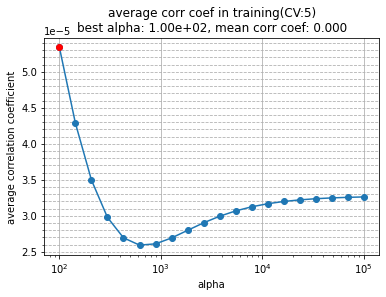

In [25]:
alpha_graph(alphas, mean_corr, best_alpha, n_cv)


In [ ]:
# 採用したalphaで学習
# どのalphaを使ったか、とか重みとかは保存しておくと良いかもしれません
rg = Ridge(alpha=best_alpha)
rg.fit(feature_trn_paired, brain_trn)

In [ ]:
# 予測
# この予測そのものも保存すると良いかも
pred_test = rg.predict(feature_test_paired)
print('pred_test shape:', pred_test.shape)

In [ ]:
# 相関&P値
corr_test = [] # (n_voxels, )

# ボクセルごとに相関を求める
for i in range(y_val.shape[1]): 
    r, _ = pearsonr(brain_test.T[i,:], pred_test.T[i,:])
    corr_test.append(r)
    
corr_test = np.array(corr_test)
p_test = compute_p(corr_test, corr_test.shape[0]) # p値を求める。これはライブラリとかを使っても求められると思います

print('corr_test shape:', np.array(corr_test).shape)
print('p_test shape:', np.array(p_test).shape)

In [ ]:
# FDR補正 0.05
p_rejected, _ = fdr(p_test)
print('p_rejected shape:', p_rejected.shape)
print('棄却されたボクセル数:', np.count_nonzero(p_rejected))

In [ ]:
# 棄却されたところのみ。可視化のために<0は0にしてしまっている
corr_rejected = np.array(corr_test)
corr_rejected[~p_rejected] = 0
corr_rejected[corr_rejected<0] = 0

In [ ]:
def corr_graph(corr, range_min=-1.0, range_max=1.0):
    '''
    相関係数のヒストグラムを作成する
    
    <<parameters>>
    corr: (b, ) 相関係数
    range_min: (float) グラフのメモリの最小
    range_max: (float) グラフのメモリの最大
    '''
    fig = plt.figure()
    mean = sum(corr)/len(corr)
    plt.title('histogram of corr coef in test\nmean corr:{:.3g}'.format(mean))
    plt.xlabel('correlation coefficient')
    plt.ylabel('number of voxels')
    plt.grid()
    plt.hist(corr, range=(range_min, range_max), bins=40)

In [ ]:
corr_graph(corr_test)


In [ ]:
# params = {
#     "figure.figsize": [6, 6],
#     "figure.autolayout": False,
#     "font.weight": "normal",
#     "font.family": "Arial", # ~/.cache/matplotlib/fontList.json shows available fonts
#     "font.size": 18,
#     "legend.fontsize": 18,
#     "lines.linewidth": .5,
#     "axes.linewidth": .5,
#     "xtick.major.width": .5,
#     "ytick.major.width": .5,
#     "pdf.fonttype": 42, # Avoid Type3 fonts
# }
# mpl.rcParams.update(params)

In [ ]:
# Subject parameters ------------------
# EPI volume size of fMRI (the first two indicate the matrix size and the last one indictes # horizontal slices)
# volume_size = [96, 96, 72]
# Subject ID (corresponding to the directory name in the pycortex filestore)
# pyctx_id = 'DK'

pred_acc = []
for i in range(n_voxels):
    pred_acc.append([corr_rejected[i]])

In [ ]:
            # + get_roi_border_vertex(freesurfer_subject_name, parcellation).data
ver = cortex.Vertex(pred_acc+get_roi_border_vertex(freesurfer_subject_name, parcellation).data, freesurfer_subject_name, cmap="hot",
                                vmin=min_val, vmax=max_val)

            # ver = cortex.Vertex(filtered_arr, freesurfer_subject_name, cmap="hot", vmin=min_val, vmax=max_val)
fig = cortex.quickflat.make_figure(ver, with_colorbar=False)
plt.axis("off")

plt.show()